In [1]:
skip_training = False
save_all = True

In [2]:
import os
if os.path.isdir('../data'):
    data_dir = '../data'
else:
    raise NotImplementedError()
print('The data directory is %s' % data_dir)

The data directory is ../data


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [4]:
device = torch.device('cpu')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root=data_dir+"/cifar-10/train", 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_dir+"/cifar-10/test", 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def plot_images(images, n_rows=1):
    fig, axes = plt.subplots(n_rows, len(images) // n_rows, figsize=(2*len(images)//n_rows,2.25*n_rows))
    for idx, image in enumerate(images):
        ax_ind = (idx%n_rows,idx//n_rows)
        if n_rows is 1:
            ax_ind = idx
        axes[ax_ind].imshow(convert_to_imshow_format(image))
        axes[ax_ind].set_title(classes[labels[idx]])
        axes[ax_ind].set_xticks([])
        axes[ax_ind].set_yticks([])
    #fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    #for ax, img in zip(axs.flat, images):
    #    ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
    #    ax.set_xticks([])
    #    ax.set_yticks([])
    #    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    #plt.tight_layout(w_pad=0)

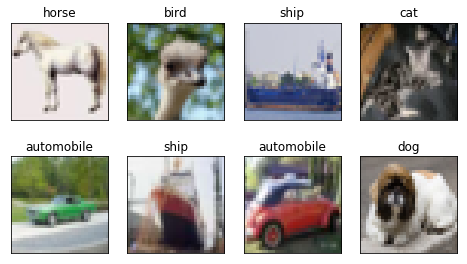

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_images(images[:8], n_rows=2)

In [8]:
class FiftyFiftyMaxAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(FiftyFiftyMaxAvgPool2d, self).__init__()
        self.avg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
        #self.a = nn.Linear(1,1,bias=False)
        self.alpha = torch.tensor([0.5]) #nn.Linear(1, 1, bias=False)
    
    def forward(self, x):
        #alpha = torch.clamp(self.a(torch.ones(1)), min=0, max=1).unsqueeze(0)
        alpha = torch.clamp(self.alpha, min=0, max=1)
        return (alpha * self.max.forward(x) + (1-alpha) * self.avg.forward(x))
        #return MixerFunction.apply(x, self.alpha)#, self.avg, self.max)


In [9]:
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MinPool2d, self).__init__()
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
    
    def forward(self, x):
        return -self.max(-x)


In [82]:
class MixerFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha, kernel_size, stride):
        avg_forward = F.avg_pool2d(x, kernel_size, stride)
        max_forward, max_ind = F.max_pool2d(x, kernel_size, stride, return_indices=True)
        kernel_size = torch.tensor([kernel_size])
        stride = torch.tensor([stride])
        ctx.save_for_backward(x, alpha, max_forward, avg_forward, max_ind, kernel_size, stride)
        return alpha * max_forward + (1-alpha) * avg_forward
    
    
    @staticmethod
    def backward(ctx, dy):
        x, alpha, max_forward, avg_forward,max_ind, kernel_size, stride = ctx.saved_tensors
        kernel_size = kernel_size.item()
        stride = stride.item()
        grad_input = grad_alpha = None
        
        if ctx.needs_input_grad[0]:
            grad_avg = F.interpolate(dy, scale_factor=stride, mode='nearest')
            grad_avg = grad_avg*1.0/(stride*stride)
            #grad_max = F.max_unpool2d(dy, max_ind, kernel_size,stride)#,output_size = x.shape)
            #print(grad_max.shape)
            grad_max = torch.zeros(x.shape).view(1,-1).squeeze(0)
            grad_max[max_ind] = dy#.view(1, -1)
            grad_max = grad_max.view(x.shape)
            grad_input = (alpha * grad_max + (1-alpha)*grad_avg)
            #print(grad_input)
        if ctx.needs_input_grad[1]:
            #print(dy.shape)
            #print(max_forward.shape)
            grad_alpha = (dy * (max_forward - avg_forward))#.sum(-1).sum(-1)
            #print(grad_alpha.shape)
            #print(grad_alpha)
            #print(max_forward - avg_forward)
            
        return grad_input, grad_alpha, None, None
    
    
class MixedMaxAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MixedMaxAvgPool2d, self).__init__()
        self.stride = stride
        self.kernel = kernel_size
        self.avg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
        #self.a = nn.Linear(1,1,bias=False)
        self.alpha = nn.Parameter(torch.rand(1, requires_grad=True)) #nn.Linear(1, 1, bias=False)
    
    #def parameters(self):
    #    return [self.alpha]
    
    def forward(self, x):
        #alpha = torch.clamp(self.a(torch.ones(1)), min=0, max=1).unsqueeze(0)
        alpha = torch.clamp(self.alpha, min=0, max=1)
        #return (alpha * self.max.forward(x) + (1-alpha) * self.avg.forward(x))
        return MixerFunction.apply(x, self.alpha, self.kernel, self.stride)#, self.avg, self.max)
    

In [83]:
# Let us test the shapes
x = torch.tensor([[1.0,-1.0,1.0,-1.0],[0,0,0,0],[1.0,-1.0,1.0,-1.0],[0,0,0,0]], requires_grad=True).unsqueeze(0).unsqueeze(0)
#print(x.shape)
act_fn = MixedMaxAvgPool2d(2,2)
print(act_fn.alpha)
lin = nn.Linear(4,1,bias=False)
lin.weight.data.fill_(0.25)
criterion = nn.MSELoss()
optimizer = optim.SGD(act_fn.parameters(), lr=0.001, momentum=0.9)

# zero the parameter gradients
optimizer.zero_grad()

# forward + backward + optimize
y = act_fn.forward(x)
#print(y)
#print(y.shape)
#print(torch.ones([1,1]).shape)
y = lin.forward(y.view(4)).unsqueeze(0)

#print(y)
#print(y.shape)
z = torch.tensor([1.0])

loss = criterion(y, z)
loss.backward()
optimizer.step()
print(act_fn.alpha)

#dy = torch.ones(1,1,1).unsqueeze(0)
#dx = act_fn.backward(dy)
#assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
#print("The shapes seem to be ok.")

Parameter containing:
tensor([0.8533], requires_grad=True)
Parameter containing:
tensor([0.8530], requires_grad=True)


In [ ]:
class GatedMaxAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MixedMaxAvgPool2d, self).__init__()
        self.stride = stride
        self.kernel = kernel_size
        self.avg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
        #self.a = nn.Linear(1,1,bias=False)
        self.alpha = nn.Parameter(torch.rand(1, requires_grad=True)) #nn.Linear(1, 1, bias=False)
    
    #def parameters(self):
    #    return [self.alpha]
    
    def forward(self, x):
        #alpha = torch.clamp(self.a(torch.ones(1)), min=0, max=1).unsqueeze(0)
        alpha = torch.clamp(self.alpha, min=0, max=1)
        #return (alpha * self.max.forward(x) + (1-alpha) * self.avg.forward(x))
        return MixerFunction.apply(x, self.alpha, self.kernel, self.stride)#, self.avg, self.max)
    

In [12]:
class Net(nn.Module):
    def __init__(self, PoolingLayer1, PoolingLayer2):
        super(Net, self).__init__()
        self.net2d = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            PoolingLayer1,
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            PoolingLayer2,)
        flat_features = 16*5*5
        self.net1d = nn.Sequential(
            nn.Linear(flat_features, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),)
        # YOUR CODE HERE
        #raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        x = self.net2d(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.net1d(x)
        return x
        #raise NotImplementedError()
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
def check_shapes(net, trainloader):
    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([32, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('The shapes seem to be ok.')

In [14]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [15]:
def train_model(net, n_epochs):
    # Define the loss and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    # Let us train the network for 10 epochs (one epoch is one pass though the training data)
    # The loss should go down during training
    net.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        print_every = 200  # mini-batches
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # Transfer to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i % print_every) == (print_every-1):
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
                running_loss = 0.0
            if skip_training:
                break

        # Print accuracy after every epoch
        accuracy = compute_accuracy(net, testloader)
        print('Accuracy of the network on the test images: %.3f' % accuracy)
        #print(net.net2d[3].a.weight)
        #print(net.net2d[7].a.weight)

        if skip_training:
            break

    print('Finished Training')

In [16]:
def save_model(net, name):
    # Save the network to a file, submit this file together with your notebook
    filename = name
    if not skip_training:
        try:
            do_save = 'yes'
            if not save_all:
                do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
            if do_save == 'yes':
                torch.save(net.state_dict(), filename)
                print('Model saved to %s' % filename)
            else:
                print('Model not saved')
        except:
            raise Exception('The notebook should be run or validated with skip_training=True.')
    else:
        net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
        net.to(device)
        print('Model loaded from %s' % filename)

In [17]:
# Let's test the shapes of the tensors
# Create a network
net = Net(nn.LPPool2d(2,2, 2), nn.LPPool2d(2,2, 2))
net.to(device)
check_shapes(net, trainloader)


Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [18]:
n_epochs = 10

In [19]:
#train_model(net, n_epochs)
#save_model(net, 'lenet-5-small_lp_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.100


In [20]:
# Let us display random images from the test set, the ground truth labels and the network's predictions
#net.eval()
#with torch.no_grad():
#    dataiter = iter(testloader)
#    images, labels = dataiter.next()
#
#    # print images
#    plot_images(images[:5], n_rows=1)
#    
#    # Compute predictions
#    images = images.to(device)
#    y = net(images)
#
#print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(4)))
#print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [21]:
# Let us look at the confusion matrix computed for the test set
import sklearn.metrics as skmetrics

def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    return skmetrics.confusion_matrix(true_labels, predictions)

Text(33,0.5,'true labels')

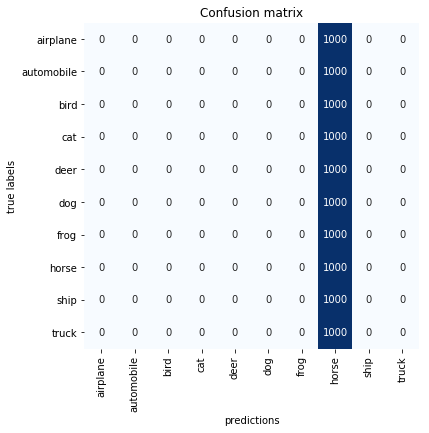

In [22]:
import seaborn as sns

c_matrix = confusion_matrix(net, testloader)
plt.figure(figsize=(6, 6))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

In [23]:
# Let's test the shapes of the tensors
# Create a network
net = Net(nn.MaxPool2d(2, 2), nn.MaxPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [24]:
#train_model(net, n_epochs)
#save_model(net, 'lenet-5-small_max_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.100


In [25]:
# Let's test the shapes of the tensors
# Create a network
net = Net(nn.AvgPool2d(2, 2), nn.AvgPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [26]:
#train_model(net, n_epochs)
#save_model(net, 'lenet-5-small_avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.100


In [27]:
# Let's test the shapes of the tensors
# Create a network
net = Net(FiftyFiftyMaxAvgPool2d(2, 2), FiftyFiftyMaxAvgPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [28]:
#train_model(net, n_epochs)
#save_model(net, 'lenet-5-small_5050_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.100


In [29]:
# Let's test the shapes of the tensors
# Create a network
net = Net(nn.MaxPool2d(2, 2), nn.AvgPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [30]:
train_model(net, n_epochs)
save_model(net, 'lenet-5-small_max+avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

[1,   200] loss: 2.296
[1,   400] loss: 2.249
[1,   600] loss: 2.150
[1,   800] loss: 2.036
[1,  1000] loss: 1.958
[1,  1200] loss: 1.881
[1,  1400] loss: 1.823
Accuracy of the network on the test images: 0.344
[2,   200] loss: 1.765
[2,   400] loss: 1.669
[2,   600] loss: 1.590
[2,   800] loss: 1.563
[2,  1000] loss: 1.534
[2,  1200] loss: 1.486
[2,  1400] loss: 1.471
Accuracy of the network on the test images: 0.462
[3,   200] loss: 1.433
[3,   400] loss: 1.421
[3,   600] loss: 1.410
[3,   800] loss: 1.390
[3,  1000] loss: 1.397
[3,  1200] loss: 1.379
[3,  1400] loss: 1.367
Accuracy of the network on the test images: 0.517
[4,   200] loss: 1.329
[4,   400] loss: 1.330
[4,   600] loss: 1.331
[4,   800] loss: 1.302
[4,  1000] loss: 1.292
[4,  1200] loss: 1.294
[4,  1400] loss: 1.291
Accuracy of the network on the test images: 0.545
[5,   200] loss: 1.281
[5,   400] loss: 1.254
[5,   600] loss: 1.239
[5,   800] loss: 1.200
[5,  1000] loss: 1.213
[5,  1200] loss: 1.257
[5,  1400] loss: 1

In [84]:
# Let's test the shapes of the tensors
# Create a network
net = Net(MixedMaxAvgPool2d(2, 2), MixedMaxAvgPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)
print(net.net2d[3].alpha)
print(net.net2d[7].alpha)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.
Parameter containing:
tensor([0.9605], requires_grad=True)
Parameter containing:
tensor([0.6132], requires_grad=True)


In [85]:
train_model(net, n_epochs)
save_model(net, 'lenet-5-small_mixed-max-avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
print(net.net2d[3].alpha)
print(net.net2d[7].alpha)

[1,   200] loss: 2.299
[1,   400] loss: 2.278
[1,   600] loss: 2.216
[1,   800] loss: 2.107
[1,  1000] loss: 2.052
[1,  1200] loss: 1.981
[1,  1400] loss: 1.909
Accuracy of the network on the test images: 0.297
[2,   200] loss: 1.815
[2,   400] loss: 1.738
[2,   600] loss: 1.698
[2,   800] loss: 1.679
[2,  1000] loss: 1.614
[2,  1200] loss: 1.619
[2,  1400] loss: 1.563
Accuracy of the network on the test images: 0.439
[3,   200] loss: 1.541
[3,   400] loss: 1.518
[3,   600] loss: 1.484
[3,   800] loss: 1.489
[3,  1000] loss: 1.502
[3,  1200] loss: 1.600
[3,  1400] loss: 1.787
Accuracy of the network on the test images: 0.100
[4,   200] loss: nan
[4,   400] loss: nan
[4,   600] loss: nan
[4,   800] loss: nan
[4,  1000] loss: nan
[4,  1200] loss: nan
[4,  1400] loss: nan
Accuracy of the network on the test images: 0.100
[5,   200] loss: nan
[5,   400] loss: nan
[5,   600] loss: nan
[5,   800] loss: nan
[5,  1000] loss: nan
[5,  1200] loss: nan
[5,  1400] loss: nan
Accuracy of the network

Parameter containing:
tensor([nan], requires_grad=True)
Parameter containing:
tensor([nan], requires_grad=True)


In [70]:
# Let's test the shapes of the tensors
# Create a network
net = Net(MinPool2d(2, 2), MinPool2d(2, 2))
net.to(device)
check_shapes(net, trainloader)

Shape of the input tensor: torch.Size([32, 3, 32, 32])
The shapes seem to be ok.


In [71]:
train_model(net, n_epochs)
save_model(net, 'lenet-5-small_min_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

[1,   200] loss: 2.303
[1,   400] loss: 2.288
[1,   600] loss: 2.251
[1,   800] loss: 2.180
[1,  1000] loss: 2.103
[1,  1200] loss: 2.048
[1,  1400] loss: 2.031
Accuracy of the network on the test images: 0.258
[2,   200] loss: 1.962
[2,   400] loss: 1.923
[2,   600] loss: 1.896
[2,   800] loss: 1.843
[2,  1000] loss: 1.771
[2,  1200] loss: 1.744
[2,  1400] loss: 1.711
Accuracy of the network on the test images: 0.380
[3,   200] loss: 1.664
[3,   400] loss: 1.633
[3,   600] loss: 1.627
[3,   800] loss: 1.598
[3,  1000] loss: 1.588
[3,  1200] loss: 1.566
[3,  1400] loss: 1.553
Accuracy of the network on the test images: 0.451
[4,   200] loss: 1.519
[4,   400] loss: 1.503
[4,   600] loss: 1.508
[4,   800] loss: 1.484
[4,  1000] loss: 1.469
[4,  1200] loss: 1.483
[4,  1400] loss: 1.488
Accuracy of the network on the test images: 0.463
[5,   200] loss: 1.432
[5,   400] loss: 1.400
[5,   600] loss: 1.413
[5,   800] loss: 1.420
[5,  1000] loss: 1.394
[5,  1200] loss: 1.395
[5,  1400] loss: 1

epochs: 10

LP: 0.627, 0.625, 0.614

Max: 0.628, 0.632, 0.641

Avg: 0.604, 0.603, 0.628

5050: 0.612, 0.639, 0.633

max->avg: 0.634, 0.643, 0.618, 0.609

mixed: 0.617, 0.627, 0.629

min: 0.554, 0.578, 0.549

epochs: 20

LP: 0.651

max: 0.646

avg: 0.627

5050: 0.634

max->avg: 0.652